In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2
import re
import random
import json
import os
from typing import List
from torch.nn.utils.rnn import pad_sequence

In [5]:
train_img_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
train_annotation_file = '/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json'
input_resolution = 224

In [6]:
import json
from collections import OrderedDict
from pathlib import Path

def read_json(fname):
    """Read a JSON file and return its contents as a dictionary.
    
    Args:
        fname (str or Path): The path to the JSON file.

    Returns:
        dict: The contents of the JSON file.
    """
    fname = Path(fname)
    with fname.open('rt') as handle:
        return json.load(handle, object_hook=OrderedDict)

In [7]:
# dataloader here
from torch.utils.data import Dataset

from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import os.path as op
import random
from transformers import CLIPTokenizer

def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=Image.BICUBIC),
        CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.4225, 0.4012, 0.3659), (0.2681, 0.2635, 0.2763)), # COCO mean, std
    ])


def get_img_id_to_img_path(annotations):
    img_id_to_img_path = {}
    for img_info in annotations['images']:
        img_id = img_info['id']
        file_name = img_info['file_name']
        img_id_to_img_path[img_id] = file_name
    
    return img_id_to_img_path

def get_img_id_to_captions(annotations):
    img_id_to_captions = {}
    for caption_info in annotations['annotations']:
        img_id = caption_info['image_id']
        if img_id not in img_id_to_captions:
            img_id_to_captions[img_id] = []
        
        caption = caption_info['caption']
        img_id_to_captions[img_id].append(caption)
    
    return img_id_to_captions

class CLIP_COCO_dataset(Dataset):
    """CLIP_COCO_dataset. To train CLIP on COCO-Captions."""

    def __init__(self, text_tokenizer, context_length=77, input_resolution=224):
        
        super(CLIP_COCO_dataset, self).__init__()

        annotation_file = train_annotation_file
        # print("annotation_file : ", annotation_file)
        annotations = read_json(annotation_file)

        self.img_id_to_filename = get_img_id_to_img_path(annotations)
        # print("img_id_to_filename : ", self.img_id_to_filename)

        self.img_id_to_captions = get_img_id_to_captions(annotations)

        self.img_ids = list(self.img_id_to_filename.keys())
        # print("total image ids = ", len(self.img_ids))

        self.img_dir = train_img_dir
        # print("img dir : ", self.img_dir)

        self.transform = _transform(input_resolution)
        self.context_length = context_length
        self._tokenizer = text_tokenizer


    def tokenize(self, text):
        # Tokenizing using BPE tokenizer with special tokens
        tokens = self._tokenizer(
            text, 
            max_length=self.context_length, 
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return tokens["input_ids"].squeeze()  # shape: (context_length,)
    
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        # randomly picking one caption from the image captions
        text = random.choice(self.img_id_to_captions[img_id])

        img_filename = self.img_id_to_filename[img_id]

        img_path = op.join(self.img_dir, img_filename)
        img = Image.open(img_path)
        img_input = self.transform(img)
        text_input = self.tokenize(text)

        return img_input, text_input

In [8]:
# Initialize 
clip_coco_dataset = CLIP_COCO_dataset(CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32'))
train_loader = DataLoader(clip_coco_dataset, batch_size=32, shuffle=True, num_workers=4)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads


    def forward(self, x, causal_mask=False):

        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        meantim_embd_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(meantim_embd_shape).transpose(1, 2)
        k = k.view(meantim_embd_shape).transpose(1, 2)
        v = v.view(meantim_embd_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Masking where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            weight.masked_fill_(mask, -torch.inf)

        # Dividing by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output

In [10]:
class CLIPEmbedding(nn.Module):
    def __init__(self, n_vocab: int, n_embd: int, n_token: int):   ## n_token = context length
        super().__init__()
        
        self.token_embedding = nn.Embedding(n_vocab, n_embd)
        # A learnable weight matrix encodes the position information for each token instead of ussing the sinsiudol functions
        self.position_embedding = nn.Parameter(torch.zeros((n_token, n_embd)))
    
    def forward(self, tokens):
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim) 
        x = self.token_embedding(tokens)
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        x += self.position_embedding       ## finally retruning the token_embd + positional_embd
        
        return x

In [11]:
class CLIPLayer(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        
        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x
        
        ### SELF ATTENTION ###

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.attention(x, causal_mask=True)
        
        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension. 

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)
        
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)
        
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function found best for this work
        
        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)
        
        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        return x

In [12]:
class CLIP(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = CLIPEmbedding(49408, 768, 77)   ## vocab_size = 49408, embedding= 768, context_len= 77 

        self.layers = nn.ModuleList([
            CLIPLayer(12, 768) for i in range(12)   ## 12 = no of heads
        ])

        self.layernorm = nn.LayerNorm(768)
    
    def forward(self, tokens: torch.LongTensor) -> torch.FloatTensor:
        tokens = tokens.type(torch.long)
        
        # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
        state = self.embedding(tokens)

        # Applying encoder layers similar to the Transformer's encoder.
        for layer in self.layers: 
            # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
            state = layer(state)
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.layernorm(state)
        
        return output

In [13]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_heads=12, embed_dim=768, depth=12):
        super(VisionTransformer, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Creating patch embedding
        self.patch_embedding = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.position_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads) for _ in range(depth)
        ])
        
        self.layernorm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: (batch_size, in_channels, height, width)
        batch_size = x.shape[0]
        x = self.patch_embedding(x)  # (batch_size, embed_dim, num_patches_height, num_patches_width)
        x = x.flatten(2).transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        class_token = self.class_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((class_token, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Adding positional embedding
        x += self.position_embedding
        
        # Applying transformer layers
        for layer in self.transformer_layers:
            x = layer(x)

        # Final layer normalization
        x = self.layernorm(x)
        
        return x   # output (batchsize, num_patches + 1, embed_dim)



In [14]:
import seaborn as sns
from tqdm import tqdm

class CLIPTrainer(nn.Module):
    def __init__(self, num_epochs: int = 25):
        super(CLIPTrainer, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initializing the text and image encoders
        self.text_encoder = CLIP().to(self.device) 
        self.image_encoder = VisionTransformer().to(self.device) 
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07)) 
        # Optimizer
        self.optimizer = optim.Adam(
            self.parameters(), lr=5e-5
        )
        self.num_epochs = num_epochs


    def forward(self, text: torch.Tensor, images: torch.Tensor):
        text_features = self.text_encoder(text)
        image_features = self.image_encoder(images)
        
        # Normalizing features for better performance
        text_features = F.normalize(text_features, dim=-1)
        image_features = F.normalize(image_features, dim=-1)

        return text_features, image_features

    def train_model(self, train_loader: DataLoader) -> List[float]:
        self.to(self.device)
        loss_history = []
        accumulation_steps = 64  # for effective batch size (e.g., 64 * 8 = 512)
        
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            print(f"Epoch {epoch + 1}/{self.num_epochs}")
            # Calculating the logit scale once per epoch
            # logit_scale = self.logit_scale.exp()
            
            # Adding progress bar for batch iteration
            for batch_idx, (images, texts) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)):
                images, texts = images.to(self.device), texts.to(self.device)

                # Zero gradients at start of accumulation step
                if batch_idx % accumulation_steps == 0:
                    self.optimizer.zero_grad()
                
                
                # Forward pass (Batch_Size, Seq_Len, Dim) and (batchsize, num_patches = 197, embed_dim)
                text_features, image_features = self.forward(texts, images)
                
                # print("image_features  ", image_features.shape)
                # print("text_features  ", text_features.shape)
                
                # (batchsize, num_patches = 197, embed_dim) -> (batchsize,  embed_dim)  [mean] -> (batchsize, embed_dim)
                image_features_agg = F.normalize(image_features.mean(dim=1), dim=-1)
                text_features_agg = F.normalize(text_features.mean(dim=1), dim=-1)
                
                # print("image_features_agg  ", image_features_agg.shape)
                # print("text_features_agg  ", text_features_agg.shape)

                # Compute similarity matrix
                logits_per_image =   self.logit_scale.exp() * torch.matmul(image_features_agg, text_features_agg.T)   # (batch_size * batch_size)
                # print("logits_per_image  ", logits_per_image.shape)
                
                logits_per_text = logits_per_image.T
                # print("logits_per_text  ", logits_per_text.shape)

                # Label: Each image-caption pair in the batch is treated as a positive pair
                # labels => (batchsize)
                labels = torch.arange(len(image_features)).to(self.device)
                # print("lables ", labels.shape)

                # Cross-entropy loss in both directions
                image_to_text_loss = F.cross_entropy(logits_per_image, labels)
                text_to_image_loss = F.cross_entropy(logits_per_text, labels)

                # Total contrastive loss
                loss = (image_to_text_loss + text_to_image_loss) / 2
                loss.backward(retain_graph=True)
                
                # Step optimizer only after full accumulation steps
                if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    self.optimizer.step()
                    self.optimizer.zero_grad()  # Clear gradients for next accumulation
                    
                    
                epoch_loss += loss.item()

            avg_loss = epoch_loss / len(train_loader)
            loss_history.append(avg_loss)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss}")

            # Save checkpoint for each epoch
            checkpoint_path = f"clip_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': self.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")

        return loss_history

    def resume_training(self, train_loader: DataLoader, checkpoint_path: str, new_lr: float = None) -> List[float]:
        # Loading checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        loss_history = [checkpoint['loss']]
        

        # Updatign learning rate if a new one is provided
        if new_lr is not None:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = new_lr
            print(f"Learning rate updated to {new_lr}")
    
        self.to(self.device)
    
        for state in self.optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(self.device)
    
        for epoch in range(start_epoch, self.num_epochs):
            epoch_loss = 0.0
            print(f"Epoch {epoch + 1}/{self.num_epochs}")
    
            for batch_idx, (images, texts) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False)):
                images, texts = images.to(self.device), texts.to(self.device)
    
                if batch_idx % 64 == 0:
                    self.optimizer.zero_grad()
    
                # Forward pass
                text_features, image_features = self.forward(texts, images)
                image_features_agg = F.normalize(image_features.mean(dim=1), dim=-1)
                text_features_agg = F.normalize(text_features.mean(dim=1), dim=-1)
                logits_per_image = self.logit_scale.exp() * torch.matmul(image_features_agg, text_features_agg.T)
                logits_per_text = logits_per_image.T
                labels = torch.arange(len(image_features)).to(self.device)
    
                # Contrastive loss
                image_to_text_loss = F.cross_entropy(logits_per_image, labels)
                text_to_image_loss = F.cross_entropy(logits_per_text, labels)
                loss = (image_to_text_loss + text_to_image_loss) / 2
                loss.backward(retain_graph=True)
    
                if (batch_idx + 1) % 64 == 0 or (batch_idx + 1) == len(train_loader):
                    self.optimizer.step()
                    self.optimizer.zero_grad()
    
                epoch_loss += loss.item()
    
            avg_loss = epoch_loss / len(train_loader)
            loss_history.append(avg_loss)
            print(f"Epoch [{epoch+1}/{self.num_epochs}], Loss: {avg_loss}")
    
            checkpoint_path = f"clip_epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': self.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
            print(f"Checkpoint saved at {checkpoint_path}")
    
        return loss_history   

In [15]:
ct = CLIPTrainer(num_epochs=100)
# ct.resume_training(train_loader, checkpoint_path="/kaggle/input/clipepoch29/clip_epoch_29.pth")

In [ ]:
ct.resume_training(train_loader, checkpoint_path="/kaggle/working/clip_epoch_81.pth", new_lr=5e-6)

In [16]:
# Load the checkpoint
checkpoint = torch.load('/kaggle/working/clip_epoch_81.pth')  # Adjust the path and filename as needed

# Load the model state
ct.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state/kaggle/working/clip_epoch_9.pth
ct.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Get the last epoch number (optional)
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch if needed


/tmp/ipykernel_30/3526412580.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/clip_epoch_81.pth')  # Adjust the path and filename

In [ ]:
loss_history = ct.train_model(train_loader)

In [18]:
def_tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-base-patch32')
def the_tokenizer(text):
        tokens = def_tokenizer(
            text, 
            max_length=77,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        return tokens["input_ids"].squeeze()  # shape: (context_length,)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
def zero_shot_classification(image: torch.Tensor, class_labels: List[str]):
    """ Function to classify the image with class labels and view all similarity scores """
    # Encode image
    ct.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Added batch dimension
        image_features = ct.image_encoder(image)
        image_features = F.normalize(image_features, dim=-1)
        image_features = F.normalize(image_features.mean(dim=1), dim=-1)

    # Encode class labels as text
    class_text_features = []
    for label in class_labels:
        text_tokens = the_tokenizer(label).to(device)
        text_tokens = text_tokens.unsqueeze(0)
        with torch.no_grad():
            text_features = ct.text_encoder(text_tokens)
            text_features = F.normalize(text_features, dim=-1)
            class_text_features.append(F.normalize(text_features.mean(dim=1), dim=-1))

    class_text_features = torch.stack(class_text_features).squeeze(1)

    # Computing similarities
    similarities = ct.logit_scale.exp() * torch.matmul(image_features, class_text_features.T)
    
    # Converting similarities to a list of scores for each label
    similarity_scores = similarities.squeeze().tolist()
    
    # Pairing each label with its corresponding similarity score
    label_scores = {label: score for label, score in zip(class_labels, similarity_scores)}
    
    return label_scores

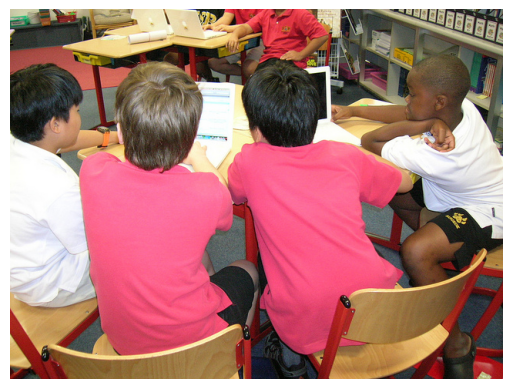

Similarity scores for each class:
person: 1.5793
man: 0.7098
boy: 1.2916
woman: 1.1357
sky: 0.9734
girl: 1.8955
bus: -1.0954
tables: 0.4135
books: 0.9061
laptop: 0.7637
students: 1.1586
children: 1.9778
chairs: -1.3731

The predicted class is: children


In [20]:
from PIL import Image

# Path to your image and class labels
image_path = "/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000345.jpg"
# class_labels = ["dog", "cat", "car", "person", "man", "woman", "sky", "girl", "bus", "water", "cow", "rock", "coat", "baseball", "goggles", "bat", "glass", "chairs", "boy", "cab", "bed",  "snow", "fire", "truck", "remote", "bird", "grass", "Giraffe", "bike", "road", "train", "zebra", "elephant", "ball", 'stick', 'badminton']
# class_labels = ["dog", "cat", "car", "person", "man", "boy", "woman", "sky", "girl", "bus", 'skateboard']
class_labels = ["person", "man", "boy", "woman", "sky", "girl", "bus", 'tables', "books", "laptop", "students", "children", "chairs"]



# Preprocessing pipeline (adjust based on your model's requirements)
preprocess = transforms.Compose([
        Resize(224, interpolation=Image.BICUBIC),
        CenterCrop(224),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.4225, 0.4012, 0.3659), (0.2681, 0.2635, 0.2763)), # COCO mean, std
    ])

# Load and preprocess image
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis('off')
plt.show()
image_tensor = preprocess(image).to(device)


# similarity scores for each class label
label_scores = zero_shot_classification(image_tensor, class_labels)

print("Similarity scores for each class:")
for label, score in label_scores.items():
    print(f"{label}: {score:.4f}")

# the best matching class
best_class = max(label_scores, key=label_scores.get)
print(f"\nThe predicted class is: {best_class}")

In [21]:
def plot_similarity_heatmap(clip_model, train_loader: DataLoader, isBatch=False):
    images, texts = next(iter(train_loader))  # Get the first batch
    batch_size = images.size(0)
    if(isBatch == False):
        # Select a random index from the batch
        idx = random.randint(0, batch_size - 1)
        random_image = images[idx].unsqueeze(0)  # Add batch dimension
        random_text = texts[idx].unsqueeze(0)    # Add batch dimension

        # Encode the random image and text
        with torch.no_grad():
            random_image_features = clip_model.image_encoder(random_image.to(device))
            random_text_features = clip_model.text_encoder(random_text.to(device))

        # Compute similarity between image and text features
        similarity = torch.matmul(random_image_features, random_text_features.transpose(1, 2)) 

        similarity = similarity.squeeze(0)
        plt.figure(figsize=(6, 5))
        sns.heatmap(similarity.cpu().numpy(), annot=True, cmap="viridis")
        plt.title("Similarity Heatmap for Random Image-Text Pair")
        plt.xlabel("Text Feature")
        plt.ylabel("Image Feature")
        plt.show()
    else:

        with torch.no_grad():
            batch_image_features = clip_model.image_encoder(images.to(device))
            batch_text_features = clip_model.text_encoder(texts.to(device))

        # Compute similarity between each image-text pair in the batch
        batch_similarity = torch.matmul(batch_image_features, batch_text_features.transpose(1, 2))


        plt.figure(figsize=(10, 8))
        sns.heatmap(batch_similarity.cpu().numpy(), annot=True, cmap="viridis")
        plt.title("Similarity Heatmap for Batch of Image-Text Pairs")
        plt.xlabel("Text Features")
        plt.ylabel("Image Features")
        plt.show()

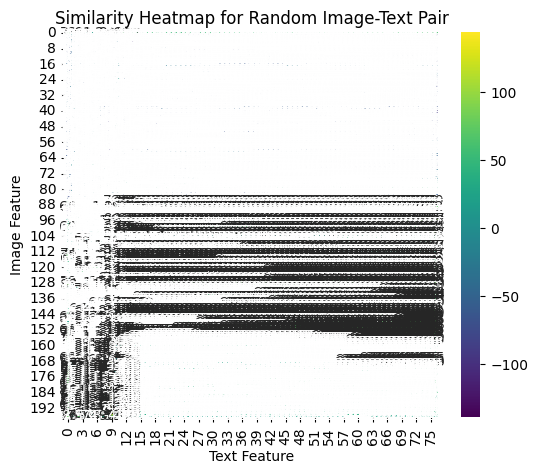

In [22]:
plot_similarity_heatmap(ct, train_loader)

In [27]:
## CLEAR THE GPU MEMORY
import torch

# Clear cache
torch.cuda.empty_cache()

# Optionally, you can also clear out all cached tensors to release memory
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   1447 MiB |   1447 MiB |   1447 MiB |      0 B   |\n|       from large pool |   1444 MiB |   1444 MiB |   1444 MiB |      0 B   |\n|       from small pool |      3 MiB |      3 MiB |      3 MiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |   1447 MiB |   1447 MiB |   1447 MiB |      0 B   |\n|       from large pool |   1444 MiB |   1444 MiB |

In [28]:
# Initialize your model
model = CLIPTrainer(num_epochs=10)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters: {num_params}')


Total number of parameters: 189972481


In [21]:
from IPython.display import FileLink

# Create a downloadable link for the zip file
FileLink('clip_epoch_81.pth')


/kaggle/working/clip_epoch_81.pth

In [19]:
### Replace file1.txt and file2.csv with the actual file names you want to delete
# !rm /kaggle/working/clip_epoch_76.pth